In [1]:
import pandas as pd
from ast import literal_eval
import numpy as np
from scipy.spatial.distance import euclidean, pdist, squareform
from os.path import join as os_join
import seaborn as sns
import matplotlib.pylab as plt

# Setting random seed
seed = 123
# Measuring run time
from time import time
# Data manipulation/analysis
import numpy as np
import pandas as pd
# Data partitioning
from sklearn.model_selection import train_test_split
# Text preprocessing/analysis
import re, random
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from spellchecker import SpellChecker


# Dataset
from sklearn.datasets import fetch_20newsgroups
# Data manipulation
import numpy as np
import pandas as pd
from collections import defaultdict
pd.options.display.max_colwidth = 100
# Text preprocessing and modelling
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.model_selection import train_test_split
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='talk')
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim

import nltk
nltk.download('averaged_perceptron_tagger')

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
# Stopwords
stop_words = set(STOPWORDS).union(stopwords.words("english"))
stop_words = stop_words.union([   'shall', 'cannot', 'could', 'done', 'let', 'may' 'mayn', 
                               'might',  'must', 'need', 'ought', 'oughtn', 
                       'shall', 'would', 'br'])
print(f"Number of stop words: {len(stop_words)}")

# pd.set_option('display.max_colwidth', None)


Number of stop words: 397


In [2]:
def convert_to_american(token):
    # Copied from here
    token = re.sub(r"(...)our$", r"\1or", token)
    token = re.sub(r"([bt])re$", r"\1er", token)
    token = re.sub(r"([iy])s(e$|ing|ation)", r"\1z\2", token)
    token = re.sub(r"ogue$", "og", token)
    return token
def correct_typo(tokens):
    spell = SpellChecker()
    return [spell.correction(t) if len(spell.unknown([t]))>0 else t for t in tokens]
        
def preprocess_text_2(text, stop_words):
    # 1. Tokenise to alphabetic tokens
    tokeniser = RegexpTokenizer(r'[A-Za-z]+')
    tokens = tokeniser.tokenize(text)
    
    # 2. Lowercase and lemmatise
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t.lower(), pos='v') for t in tokens]
    
    # 3. Correct spelling (this won't convert 100% )
    # tokens = correct_typo(tokens)
    
    # 4. Convert British spelling to American spelling (this won't convert 100%)
    # tokens = [convert_to_american(t) for t in tokens]
    
    # 5. Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    
    return tokens

def preprocess_text(text, stop_words, pos_to_keep=None):
    """Preprocess document into normalised tokens."""
    # Tokenise into alphabetic tokens with minimum length of 3
    tokeniser = RegexpTokenizer(r'[A-Za-z]{3,}')
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and tag words with POS tag
    tokens_lower = [token.lower() for token in tokens]
    pos_map = {'J': 'a', 'N': 'n', 'R': 'r', 'V': 'v'}
    pos_tags = pos_tag(tokens_lower)
    
    # Keep tokens with relevant pos
    if pos_to_keep is not None:
        pos_tags =  [token for token in pos_tags if token[1][0] in pos_to_keep]  
    
    # Lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(t, pos=pos_map.get(p[0], 'v')) for t, p in pos_tags]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stop_words]
    return keywords



example = ["We played board games yesterday.",
           "Mangos are delicious!",
           "She plays board games every weekend.",
           "Mangoes are now in season. Buy them while they are cheap."]

documents = [preprocess_text(document, stop_words) for document in example]
documents

[['play', 'board', 'game', 'yesterday'],
 ['mango', 'delicious'],
 ['play', 'board', 'game', 'weekend'],
 ['mango', 'season', 'buy', 'cheap']]

In [3]:
model_path = "../models/doc2vec/d2v.model"
dataset = pd.read_csv("../data/processed/vis_dataset/vis_data.csv")
dataset.shape

(1746, 21)

In [4]:
dataset.head(2)

,Conference,Year,Title,DOI,id,cite_to_list,cited_by_list,Link,FirstPage,LastPage,...,Abstract,AuthorNames-Deduped,AuthorNames,AuthorAffiliation,InternalReferences,AuthorKeywords,AminerCitationCount_02-2020,XploreCitationCount - 2020-01,PubsCited,Award
0,InfoVis,1995,Visualisation for functional design,10.1109/INFVIS.1995.528680,0,[],[990],http://dx.doi.org/10.1109/INFVIS.1995.528680,4,10,...,We present two novel visualisation tools: the Influence Explorer and the Prosection Matrix. Thes...,Robert Spence;Lisa Tweedie;Huw Dawkes;Hua Su,B. Spence;L. Tweedie;H. Dawkes;Hua Su,"Dept. of Electr. Eng., Imperial Coll. of Sci., Technol. & Med., London, UK;Dept. of Electr. Eng....",NaN,NaN,NaN,12.0,10.0,NaN
1,InfoVis,1995,Towards a generative theory of diagram design,10.1109/INFVIS.1995.528681,1,[],[],http://dx.doi.org/10.1109/INFVIS.1995.528681,11,18,...,"We describe the theoretical background for AVE, an automatic visualization engine for semantic n...",Klaus Reichenberger;Thomas Kamps;Gene Golovchinsky,K. Reichenberger;T. Kamps;G. Golovchinsky,"GMD-Inst. for Integrated Publication & Inf. Sci., Darmstadt, Germany;GMD-Inst. for Integrated Pu...",10.1109/VISUAL.1995.480815,NaN,12.0,4.0,18.0,NaN


In [5]:
# import gensim

# from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# from nltk.tokenize import word_tokenize
# import collections


# # data = [gensim.utils.simple_preprocess(p) for p in dataset.Abstract]
# data = [preprocess_text(document, stop_words) for document in dataset.Abstract]

# documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data)]

# for epoch in [13,15,17,20]:
#     model = Doc2Vec(vector_size=50,  min_count=5, workers=4, epochs = epoch, dm=1)
#     model.build_vocab(documents=documents)

#     model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)



#     ranks = []
#     second_ranks = []
#     for doc_id in range(len(documents)):
#     #     test_data = word_tokenize(documents[doc_id].words)
#         test_data = documents[doc_id].words

#         inferred_vector = model.infer_vector(test_data)
#         sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
#         rank = [docid for docid, sim in sims].index(doc_id)
#         ranks.append(rank)

#         second_ranks.append(sims[1])

#     # Let's count how each document ranks with respect to the training corpus
#     # NB. Results vary between runs due to random seeding and very small corpus

#     counter = collections.Counter(ranks)
#     print("epoch=", epoch)
#     print(counter[0]/sum(counter.values()))
#     print(counter)
#     print("-----")


In [6]:
import gensim

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import collections


data = [preprocess_text(p, stop_words) for p in dataset.Abstract]

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data)]

epoch=16
model = Doc2Vec(vector_size=50,  min_count=5, workers=4, epochs = epoch, dm=1)
model.build_vocab(documents=documents)

model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)



ranks = []
second_ranks = []
for doc_id in range(len(documents)):
#     test_data = word_tokenize(documents[doc_id].words)
    test_data = documents[doc_id].words

    inferred_vector = model.infer_vector(test_data)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

# Let's count how each document ranks with respect to the training corpus
# NB. Results vary between runs due to random seeding and very small corpus

counter = collections.Counter(ranks)
print("epoch=", epoch)
print(counter[0]/sum(counter.values()))
print(counter)
print("-----")


epoch= 16
0.993127147766323
Counter({0: 1734, 1: 10, 19: 1, 9: 1})
-----


In [7]:
from gensim.test.utils import get_tmpfile
# model.save(model_path)
# >>> model = Doc2Vec.load(fname)  # you can continue training with the loaded model!


In [8]:
def output_sentences(most_similar):
    for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(most_similar)//2), (f'LEAST ({len(most_similar)}th)', len(most_similar) - 1)]:
        
        print("label=", label)
        print("index=", index)
        print(u'%s %s: %s\n' % (label, most_similar[index][1], " ".join(data[int(most_similar[index][0])])))

In [9]:
embedding_vectors = model.docvecs.vectors_docs
embedding_vectors.shape

(1746, 50)

In [16]:
from scipy import spatial

embedding_vectors = model.docvecs.vectors_docs
embedding_vectors.shape
cosine_sim = 1 - spatial.distance.cosine(embedding_vectors[0], embedding_vectors[2])
cosine_sim

0.5426613092422485

In [45]:
def get_doc2vec_similarity(model):
    """
        https://stackoverflow.com/questions/41905029/create-cosine-similarity-matrix-numpy
    """
    embedding_vectors = model.docvecs.vectors_docs
    embedding = embedding_vectors.T
   
    norm = (embedding * embedding).sum(0, keepdims=True) ** .5
    embedding_norm = embedding/norm
    similarity_matrix = embedding_norm.T @ embedding_norm
    return similarity_matrix


import matplotlib.pyplot as plt
import numpy as np


def heatmap2d(arr, img_path=None):
    plt.figure(figsize=(15,10))
    
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    if img_path:
        plt.savefig(img_path)
        print("saved image!")
 




In [50]:
tmp = pd.DataFrame(doc2vec_similarity, index=list(range(len(doc2vec_similarity))))
tmp

,0,1,2,3,4,5,6,7,8,9,...,1736,1737,1738,1739,1740,1741,1742,1743,1744,1745
0,1.000000,0.569519,0.542661,0.423739,0.595018,0.583753,0.474647,0.664606,0.481825,0.444518,...,0.725676,0.279238,0.653036,0.638626,0.454539,0.687162,0.478998,0.626648,0.744452,0.633143
1,0.569519,1.000000,0.673208,0.637577,0.277507,0.428085,0.355681,0.475415,0.464362,0.625836,...,0.389142,0.565181,0.594237,0.555568,0.339492,0.083638,0.775932,0.343008,0.409764,0.527010
2,0.542661,0.673208,1.000000,0.342018,0.244254,0.621841,0.540500,0.528496,0.520937,0.280289,...,0.148116,0.360332,0.394531,0.468787,0.357348,0.212791,0.715948,0.098112,0.078979,0.287146
3,0.423739,0.637577,0.342018,1.000000,0.368185,0.260178,0.207388,0.249144,0.467634,0.798057,...,0.355575,0.651605,0.456248,0.102961,0.318119,0.187617,0.460978,0.346281,0.610910,0.323563
4,0.595018,0.277507,0.244254,0.368185,1.000000,0.540411,0.351634,0.530285,0.717083,0.492767,...,0.337612,0.144198,0.399040,0.486779,0.545082,0.575876,0.055840,0.390247,0.570620,0.403542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,0.687162,0.083638,0.212791,0.187617,0.575876,0.430375,0.290513,0.425174,0.350408,0.094877,...,0.608582,-0.077380,0.401395,0.376784,0.429274,1.000000,0.217590,0.638852,0.612782,0.416075
1742,0.478998,0.775932,0.715948,0.460978,0.055840,0.287834,0.505831,0.259642,0.382039,0.335987,...,0.342550,0.517750,0.652434,0.479011,0.384713,0.217590,1.000000,0.429929,0.210843,0.497406
1743,0.626648,0.343008,0.098112,0.346281,0.390247,0.125449,0.445101,0.205416,0.244099,0.182027,...,0.652042,0.146640,0.748175,0.473419,0.521538,0.638852,0.429929,1.000000,0.727717,0.701900
1744,0.744452,0.409764,0.078979,0.610910,0.570620,0.306106,0.193361,0.466030,0.307271,0.564010,...,0.767578,0.218529,0.564346,0.348269,0.306363,0.612782,0.210843,0.727717,1.000000,0.540766


saved image


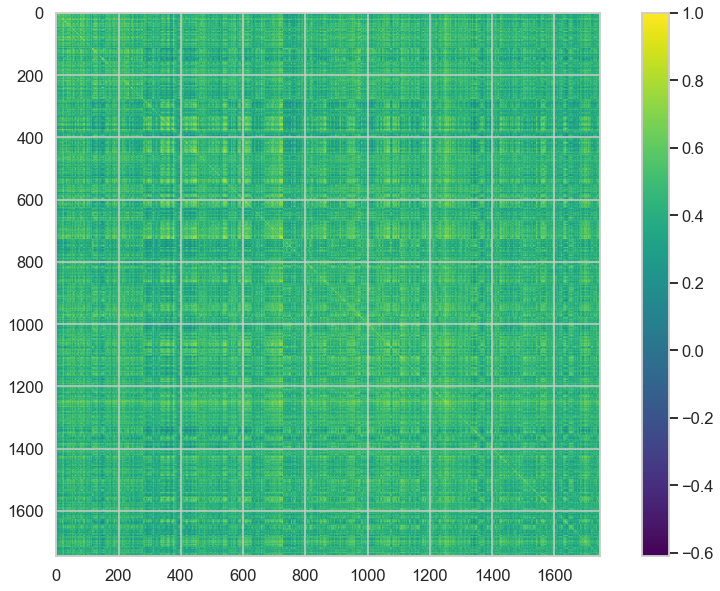

In [46]:
doc2vec_similarity = get_doc2vec_similarity(model)

heatmap2d(doc2vec_similarity, "/Users/chaupham/Downloads/a.png")

## Test Doc2Vec's results

In [14]:
my_paper = dataset.Abstract[10]
test_data = preprocess_text(my_paper, stop_words)
v_my_paper = model.infer_vector(test_data)
print(v_my_paper)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar([embedding_vectors[10]])
print(similar_doc)

# to print similar sentences
output_sentences(similar_doc) 

[-0.14734647 -0.51121575  0.09619219  0.3998498  -0.37096086 -0.04071375
 -0.1417172   0.6144509   0.05350088 -0.6414062   0.61227435 -0.2926565
  0.46530643 -0.90290207  0.26773414 -0.21446943 -0.44829157 -0.26829714
  0.33985642  0.2576146   0.34747764  0.14193231 -0.3765997   0.18719317
 -0.06550101 -0.35894492  0.15273128 -0.27867046  0.36272046  0.47028488
  0.41092134 -0.47523326 -0.01341301 -0.3002782   0.06997683 -0.09068855
 -0.3884804   0.10416529  0.25149393  0.5660186   0.61477625  0.46696374
 -0.2986539  -0.36119124 -0.33097148 -0.07918693  0.08201345  0.36304635
  0.09567694 -0.77357274]
[(10, 0.9999999403953552), (122, 0.8671226501464844), (278, 0.8576316833496094), (127, 0.8498323559761047), (80, 0.8496192693710327), (1130, 0.8429102897644043), (884, 0.8417071104049683), (46, 0.8404066562652588), (910, 0.8399747014045715), (1599, 0.8380330801010132)]
label= MOST
index= 0
MOST 0.9999999403953552: dataspace interactive visualization analysis large database dataspace utili

## Check on pre-process the data

In [ ]:
dataset_small = dataset.head()
ori = [i for i in dataset_small.Abstract]
ori

In [ ]:
data = [gensim.utils.simple_preprocess(p) for p in dataset_small.Abstract]
default_process = list(map(lambda x: " ".join(x), data))    
default_process

In [ ]:
new_process = [preprocess_text(document, stop_words) for document in dataset_small.Abstract]
new_process = list(map(lambda x: " ".join(x), new_process))    
new_process

In [ ]:
new_process_2 = [preprocess_text_2(document, stop_words) for document in dataset_small.Abstract]
new_process_2 = list(map(lambda x: " ".join(x), new_process_2))    
new_process_2

In [ ]:
for ori_data, old_data, new_data, new_data_2 in zip(ori, default_process, new_process, new_process_2):
    print("- ori_data:", ori_data)
    print("- old_data:", old_data)
    print("- new_data:", new_data)
    print("- new_data_2:", new_data_2)

    print("=========")